In [1]:
import numpy as np
import cv2 as cv
import time
import os
import copy

In [2]:
path = '/home/fizzer/ros_ws/src/controller/node/'
img_folder = "pictures"
img_name = "left_bright_far_ns.png"
# 1 = pass, 0 = fail, first index is mb = 13, second is no median blur
# left_bright_far_ns.png [1,1]
# left_bright_no_see.png [1,1]
# left_no_see.png [1,1]
# p_left.png [0,0] - plate contour didn't show up
# p_right_close.png [1,0] - got wrong character contour
# p_right.png [0] - letters too small (far away)
full_path = os.path.join(path, img_folder, img_name)

img = cv.imread(full_path,cv.IMREAD_COLOR)

# # isolates blue
# uh = 125
# us = 255
# uv = 255
# lh = 118
# ls = 40
# lv = 40

# # isolates partial rectangle around P2 and plate
# uh = 122
# us = 117
# uv = 105
# lh = 114
# ls = 000
# lv = 89

# # used with blur - general
# uh = 176
# us = 11
# uv = 117 # 98
# lh = 115
# ls = 5 # 0
# lv = 89

# GOOD - including grass plates
uh = 176
us = 11
uv = 190
lh = 105
ls = 5 # 0
lv = 90 # 170 to 130, but for non-bright spots, 0 to 100
high_cntr_thresh = 600 # y val
low_cntr_thresh = 300

# # gray surrounding plate
# uh = 255
# us = 61
# uv = 130
# lh = 000
# ls = 000
# lv = 120

# mb = 1 # 13
# img_blur = cv.medianBlur(img,mb)
# hsv = cv.cvtColor(img_blur, cv.COLOR_BGR2HSV)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

lower_hsv = np.array([lh,ls,lv])
upper_hsv = np.array([uh,us,uv])

# Threshold the HSV image to get only blue colors
# mask = cv.inRange(hsv, lower_hsv, upper_hsv) # if in range, 1, else, 0
window_name = "HSV Calibrator"
cv.namedWindow(window_name)

def nothing(x):
    print("Trackbar value: " + str(x))
    pass

# create trackbars for Upper HSV
cv.createTrackbar('UpperH',window_name,0,255,nothing)
cv.setTrackbarPos('UpperH',window_name, uh)

cv.createTrackbar('UpperS',window_name,0,255,nothing)
cv.setTrackbarPos('UpperS',window_name, us)

cv.createTrackbar('UpperV',window_name,0,255,nothing)
cv.setTrackbarPos('UpperV',window_name, uv)

# create trackbars for Lower HSV
cv.createTrackbar('LowerH',window_name,0,255,nothing)
cv.setTrackbarPos('LowerH',window_name, lh)

cv.createTrackbar('LowerS',window_name,0,255,nothing)
cv.setTrackbarPos('LowerS',window_name, ls)

cv.createTrackbar('LowerV',window_name,0,255,nothing)
cv.setTrackbarPos('LowerV',window_name, lv)

font = cv.FONT_HERSHEY_SIMPLEX

while(1):
    # hsv threshold and edges
    mask = cv.inRange(hsv, lower_hsv, upper_hsv)
    kernel = np.ones((17,17),np.uint8)
    dilation = cv.dilate(mask,kernel,iterations=1) # https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html
    edged = cv.Canny(dilation,75,200)
    cv.imshow("dilated edges", edged)

    # get largest contour
    contours_edge, _ = cv.findContours(edged, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours_edge = sorted(contours_edge,key=cv.contourArea,reverse=True) # largest to smallest contours

    if len(contours_edge) == 0: # prevent indexing errors when no contour found
        pass
    else:
        plate_cntr_found = False
        for cntr in contours_edge:
            x_cntr, y_cntr, width_cntr, height_cntr = cv.boundingRect(cntr)
            #if bounding rectangle's y + height is too high or too low, discard it (only keep ones in middle to lower-third of screen)
            if y_cntr > low_cntr_thresh and y_cntr+height_cntr < high_cntr_thresh:
                largest_contour = cntr
                plate_cntr_found = True
                break
            else:
                continue
        # largest_contour = contours_edge[0]
        if plate_cntr_found:
            x,y,width,height = cv.boundingRect(largest_contour) # coordinates of largest contour
            plate = img[y:y+height,x:x+width] # crop to isolate plate
            cv.imshow("plate",plate)

            img_copy = copy.deepcopy(img)
            cv.drawContours(img_copy, [largest_contour], -1, (0,255,0),2)
            cv.imshow("contours",img_copy)
        else:
            continue # reset while loop

    # blue hsv mask values
    uh_plate = 125
    us_plate = 255
    uv_plate = 255
    lh_plate = 118
    ls_plate = 100 # 85 to 100
    lv_plate = 40
    lower_hsv_plate = np.array([lh_plate,ls_plate,lv_plate])
    upper_hsv_plate = np.array([uh_plate,us_plate,uv_plate])

    # mask blue
    hsv_plate = cv.cvtColor(plate, cv.COLOR_BGR2HSV)
    mask_plate = cv.inRange(hsv_plate,lower_hsv_plate,upper_hsv_plate)
    cv.imshow("mask plate",mask_plate)

    contours_plate, hierarchy = cv.findContours(mask_plate,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE) #RETR_TREE
    # if contour is inside another contour, discard it

    contours_plate = sorted(contours_plate,key=cv.contourArea,reverse=True)

    plate_copy = copy.deepcopy(plate)
    cv.drawContours(plate_copy,contours_plate,-1,(0,255,0),1)
    cv.imshow("contours plate",plate_copy)

    # contour's bounding rectangles
    bounding_rects = []
    for cntr in contours_plate:
        x,y,width,height = cv.boundingRect(cntr)
        bounding_rects.append([[x,y,width,height],(x+width * y+height)]) #[[[x,y,w,h],area], [[x,y,w,h],area], [[x,y,w,h],area]]]

    # remove bounding rectangles if blue edges present
    plate_width = plate.shape[1]
    hystersis = 5 # pixels from width of image
    bounding_rects_cropped = copy.deepcopy(bounding_rects)
    for i in bounding_rects:
        x_i = i[0][0]
        y_i = i[0][1]
        width_i = i[0][2]
        height_i = i[0][3]
        if x_i == 0 or x_i + width_i == plate_width or x_i+width_i >= plate_width - hystersis:
            bounding_rects_cropped.remove(i)

    # sort bounding rects by area
    areas = np.asarray([bounding_rects_cropped[i][1] for i in range(len(bounding_rects_cropped))])
    max_area_indicies = list(reversed(areas.argsort())) # index of max area is 0th element, descending

    # split large contours (when blue bleeds between letters)
    bounding_rects_split = copy.deepcopy(bounding_rects_cropped)
    max_rect_index = max_area_indicies[0]
    max_rect_area = areas[max_rect_index]
    split_rectangle_threshold = 1.5 # multiplication factor
    second_max_rect_area = areas[max_area_indicies[1]]
    
    # if max_rect_area >= split_rectangle_threshold*second_max_rect_area:
    if len(areas) <= 3: # if only three contours
        x_max = bounding_rects_cropped[max_rect_index][0][0]
        y_max = bounding_rects_cropped[max_rect_index][0][1]
        width_max = bounding_rects_cropped[max_rect_index][0][2]
        height_max = bounding_rects_cropped[max_rect_index][0][3]

        x_left = x_max
        width_left = int(width_max / 2) - 1
        x_right = x_max + width_left + 1
        width_right = int(width_max / 2)

        del bounding_rects_split[max_rect_index] # remove large rectangle
        bounding_rects_split.append(([[x_left,y_max,width_left,height_max],(x_left+width_left * y_max+height_max)]))
        bounding_rects_split.append(([[x_right,y_max,width_right,height_max],(x_right+width_right * y_max+height_max)]))

    areas_split = np.asarray([bounding_rects_split[i][1] for i in range(len(bounding_rects_split))])
    max_area_indicies_split = list(reversed(areas_split.argsort())) # index of max area is 0th element, descending

    # largest four bounding rectangles
    plate_rect_display = copy.deepcopy(plate)
    char_bounding_rects = []
    for k in range(4):
        rect_idx = max_area_indicies_split[k]
        x_i = bounding_rects_split[rect_idx][0][0]
        y_i = bounding_rects_split[rect_idx][0][1]
        width_i = bounding_rects_split[rect_idx][0][2]
        height_i = bounding_rects_split[rect_idx][0][3]
        char_bounding_rects.append([x_i,y_i,width_i,height_i])
        cv.rectangle(plate_rect_display,(x_i,y_i+height_i),(x_i+width_i,y_i),(0,0,255),1) # (top left), (bottom right)
    
    char_bounding_rects.sort(key=lambda char_bounding_rects : char_bounding_rects[0]) # sort based on x value, lowest = leftmost = 0th
    cv.imshow("char bounding rectangles",plate_rect_display)
    
    # isolate characters
    for c in range(len(char_bounding_rects)):
        x_c = char_bounding_rects[c][0]
        y_c = char_bounding_rects[c][1]
        width_c = char_bounding_rects[c][2]
        height_c = char_bounding_rects[c][3]
        padding = 1 # additional pixels to include, for if we crop in too much
        char = plate[y_c-padding:y_c+height_c+padding,x_c-padding:x_c+width_c+padding] # cropped char from plate
    
    # hsv slider display
    cv.putText(mask,'Lower HSV: [' + str(lh) +',' + str(ls) + ',' + str(lv) + ']', (10,30), font, 0.5, (200,255,155), 1, cv.LINE_AA)
    cv.putText(mask,'Upper HSV: [' + str(uh) +',' + str(us) + ',' + str(uv) + ']', (10,60), font, 0.5, (200,255,155), 1, cv.LINE_AA)

    cv.imshow(window_name,mask)

    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
    # get current positions of Upper HSV trackbars
    uh = cv.getTrackbarPos('UpperH',window_name)
    us = cv.getTrackbarPos('UpperS',window_name)
    uv = cv.getTrackbarPos('UpperV',window_name)
    upper_blue = np.array([uh,us,uv])
    # get current positions of Lower HSCV trackbars
    lh = cv.getTrackbarPos('LowerH',window_name)
    ls = cv.getTrackbarPos('LowerS',window_name)
    lv = cv.getTrackbarPos('LowerV',window_name)

    upper_hsv = np.array([uh,us,uv])
    lower_hsv = np.array([lh,ls,lv])

    time.sleep(.1)

cv.destroyAllWindows()

Trackbar value: 176
Trackbar value: 11
Trackbar value: 190
Trackbar value: 105
Trackbar value: 5
Trackbar value: 90


KeyboardInterrupt: 

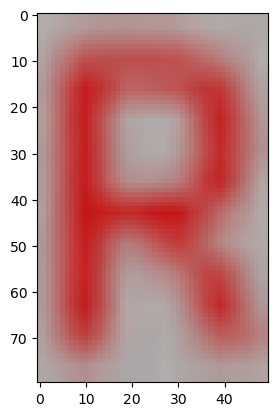

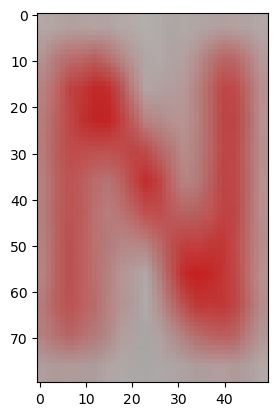

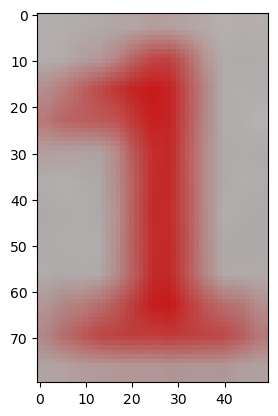

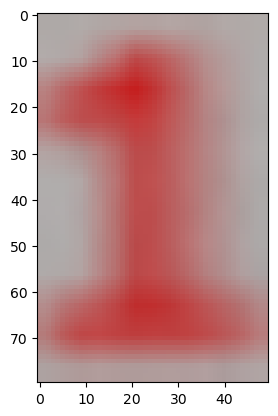

In [ ]:
# graphing isolated characters

%matplotlib inline
from matplotlib import pyplot as plt

chars = []

for c in range(len(char_bounding_rects)):
    x_c = char_bounding_rects[c][0]
    y_c = char_bounding_rects[c][1]
    width_c = char_bounding_rects[c][2]
    height_c = char_bounding_rects[c][3]
    padding = 1
    char = plate[y_c-padding:y_c+height_c+padding,x_c-padding:x_c+width_c+padding] # cropped char from plate
    chars.append(char)
    plt.imshow(cv.resize(char, (50,80)))
    plt.show()

In [ ]:
from tensorflow import keras

2022-12-05 20:16:21.270024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 20:16:21.375630: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-05 20:16:21.378298: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib

2022-12-05 20:16:25.076766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2022-12-05 20:16:25.076788: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 20:16:25.076802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skynet): /proc/driver/nvidia/version does not exist
2022-12-05 20:16:25.076974: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Ten

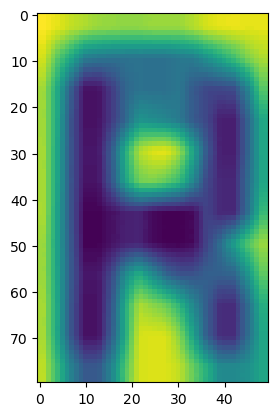

1/1 [==============================] - 0s 110ms/step


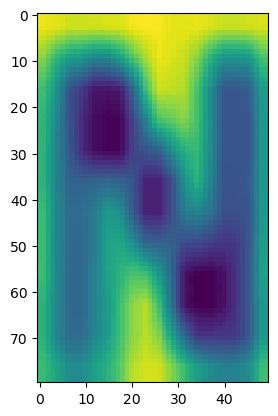

1/1 [==============================] - 0s 13ms/step


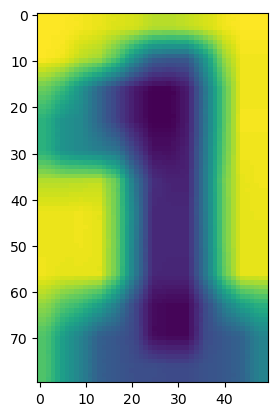

1/1 [==============================] - 0s 16ms/step


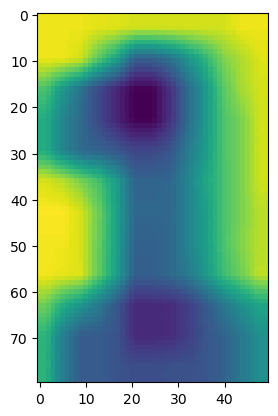

1/1 [==============================] - 0s 15ms/step


In [ ]:
# predict characters

conv_model = keras.models.load_model('/home/fizzer/ros_ws/src/controller/node/conv_model_74k')
predictions = []
for k in chars:
    kernel = np.ones((2,2),np.uint8)
    char_img = cv.erode(cv.cvtColor(k,cv.COLOR_BGR2GRAY),kernel,iterations=1) # helps "sharpen" letters, can experment with kernel size
    char_img_resized = cv.resize(char_img, (50,80))
    plt.imshow(char_img_resized)
    plt.show()
    prediction = [conv_model.predict(np.expand_dims(char_img_resized,axis=0))[0]]
    predictions.append(prediction)


In [ ]:
# show predictions

max_predictions = [np.argmax(i) for i in predictions]
max_predictions_chars = [chr(i-10+65) if i >= 11 else str(i) for i in max_predictions]
print(max_predictions)
print(max_predictions_chars)

[27, 23, 1, 1]
['R', 'N', '1', '1']


In [ ]:
## get contours (no erode seems ok)

# import numpy as np
# import cv2 as cv
# import time
# import os
# import copy

# path = '/home/fizzer/ros_ws/src/controller/node/'
# img_folder = "pictures"
# img_name = "test_char_contours.png"
# full_path = os.path.join(path, img_folder, img_name)

# # blue hsv mask values
# uh_plate = 125
# us_plate = 255
# uv_plate = 255
# lh_plate = 118
# ls_plate = 100 # 85 to 100
# lv_plate = 40
# lower_hsv_plate = np.array([lh_plate,ls_plate,lv_plate])
# upper_hsv_plate = np.array([uh_plate,us_plate,uv_plate])

# plate = cv.imread(full_path)

# # mask blue
# hsv_plate = cv.cvtColor(plate, cv.COLOR_BGR2HSV)
# mask_plate = cv.inRange(hsv_plate,lower_hsv_plate,upper_hsv_plate)
# cv.imshow("mask plate",mask_plate)

# contours_plate, hierarchy = cv.findContours(mask_plate,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE) #RETR_TREE
# # if contour is inside another contour, discard it

# contours_plate = sorted(contours_plate,key=cv.contourArea,reverse=True)

# plate_copy = copy.deepcopy(plate)
# cv.drawContours(plate_copy,contours_plate,-1,(0,255,0),1)
# cv.imshow("contours plate",plate_copy)

# # contour's bounding rectangles
# plate_rect_display = copy.deepcopy(plate)
# bounding_rects = []
# for cntr in contours_plate:
#     x,y,width,height = cv.boundingRect(cntr)
#     bounding_rects.append([[x,y,width,height],(x+width * y+height)]) #[[[x,y,w,h],area], [[x,y,w,h],area], [[x,y,w,h],area]]]

# # remove bounding rectangles if blue edges present
# plate_width = plate.shape[1]
# hystersis = 5 # pixels from width of image
# bounding_rects_cropped = copy.deepcopy(bounding_rects)
# for i in bounding_rects:
#     x_i = i[0][0]
#     y_i = i[0][1]
#     width_i = i[0][2]
#     height_i = i[0][3]
#     if x_i == 0 or x_i + width_i == plate_width or x_i+width_i >= plate_width - hystersis:
#         bounding_rects_cropped.remove(i)

# # sort bounding rects by area
# areas = np.asarray([bounding_rects_cropped[i][1] for i in range(len(bounding_rects_cropped))])
# max_area_indicies = list(reversed(areas.argsort())) # index of max area is 0th element, descending

# # split large contours (when blue bleeds between letters)
# split_rectangle_threshold = 1.5 # multiplication factor
# max_rect_index = max_area_indicies[0]
# max_rect_area = areas[max_rect_index]
# second_max_rect_area = areas[max_area_indicies[1]]

# bounding_rects_split = copy.deepcopy(bounding_rects_cropped)
# if max_rect_area >= split_rectangle_threshold*second_max_rect_area:
#     x_max = bounding_rects_cropped[max_rect_index][0][0]
#     y_max = bounding_rects_cropped[max_rect_index][0][1]
#     width_max = bounding_rects_cropped[max_rect_index][0][2]
#     height_max = bounding_rects_cropped[max_rect_index][0][3]

#     x_left = x_max
#     width_left = int(width_max / 2) - 1
#     x_right = x_max + width_left + 1
#     width_right = int(width_max / 2)

#     del bounding_rects_split[max_rect_index] # remove large rectangle
#     bounding_rects_split.append(([[x_left,y_max,width_left,height_max],(x_left+width_left * y_max+height_max)]))
#     bounding_rects_split.append(([[x_right,y_max,width_right,height_max],(x_right+width_right * y_max+height_max)]))

# areas_split = np.asarray([bounding_rects_split[i][1] for i in range(len(bounding_rects_split))])
# max_area_indicies_split = list(reversed(areas_split.argsort())) # index of max area is 0th element, descending

# # get largest four bounding rectangles
# char_bounding_rects = []
# for k in range(4):
#     rect_idx = max_area_indicies_split[k]
#     x_i = bounding_rects_split[rect_idx][0][0]
#     y_i = bounding_rects_split[rect_idx][0][1]
#     width_i = bounding_rects_split[rect_idx][0][2]
#     height_i = bounding_rects_split[rect_idx][0][3]
#     char_bounding_rects.append([x_i,y_i,width_i,height_i])
#     cv.rectangle(plate_rect_display,(x_i,y_i+height_i),(x_i+width_i,y_i),(0,0,255),1) # (top left (x,y)), (bottom right (x,y))

# char_bounding_rects.sort(key=lambda char_bounding_rects : char_bounding_rects[0]) # sort based on x value, lowest = leftmost = 0th
# cv.imshow("char bounding rectangles",plate_rect_display)
# cv.waitKey(0)

In [ ]:
## characters bounding box

# print(char_bounding_rects) #x, y, width, height

# min_x = np.amin([char_bounding_rects[i][0] for i in range(len(char_bounding_rects))])
# max_x = np.amax([char_bounding_rects[i][0] for i in range(len(char_bounding_rects))])
# min_y = np.amin([char_bounding_rects[i][1] for i in range(len(char_bounding_rects))])
# max_y = np.amax([char_bounding_rects[i][1] for i in range(len(char_bounding_rects))])
# max_width = np.amax([char_bounding_rects[i][2] for i in range(len(char_bounding_rects))])
# max_height = np.amax([char_bounding_rects[i][3] for i in range(len(char_bounding_rects))])
# points = np.array([[min_x,min_y],[min_x,max_y+max_height],[max_x+max_width,max_y+max_height],[max_x+max_width,min_y]], np.int32) #(x,y) counterclockwise from top left

# plate_points = copy.deepcopy(plate)

# for i in range(len(points)):
#     cv.circle(plate_points,points[i],radius=3,color=(255,0,0), thickness=-1)

# # polygon = cv.polylines(plate_polygon, [points], True, (255,0,0), thickness=2)
# cv.imshow("points plate", plate_points)
# cv.waitKey(0)

[[22, 21, 21, 11], [45, 20, 20, 11], [91, 18, 18, 11], [115, 18, 15, 10]]


100

In [ ]:
## perspective transform

# print(char_bounding_rects) #x, y, width, height

# min_x = np.amin([char_bounding_rects[i][0] for i in range(len(char_bounding_rects))])
# max_x = np.amax([char_bounding_rects[i][0] for i in range(len(char_bounding_rects))])
# min_y = np.amin([char_bounding_rects[i][1] for i in range(len(char_bounding_rects))])
# max_y = np.amax([char_bounding_rects[i][1] for i in range(len(char_bounding_rects))])
# max_width = np.amax([char_bounding_rects[i][2] for i in range(len(char_bounding_rects))])
# max_height = np.amax([char_bounding_rects[i][3] for i in range(len(char_bounding_rects))])

# plate_height, plate_width, _ = plate.shape
# input_pts = np.float32([[min_x,min_y],[min_x, max_y+max_height],[max_x+max_width,max_y+max_height],[max_x,min_y]])
# output_pts = np.float32([[0,0],[0,plate_height],[plate_width,plate_height],[plate_width,0]]) #(x,y)
# matrix = cv.getPerspectiveTransform(input_pts, output_pts)
# plate_transformed = cv.warpPerspective(plate,matrix, (plate_width, plate_height))

# cv.imshow("transformed plate", plate_transformed)
# cv.waitKey(0)


[[22, 21, 21, 11], [45, 20, 20, 11], [91, 18, 18, 11], [115, 18, 15, 10]]


In [ ]:
## affine transform

# print(char_bounding_rects) #x, y, width, height

# min_x = np.amin([char_bounding_rects[i][0] for i in range(len(char_bounding_rects))])
# max_x = np.amax([char_bounding_rects[i][0] for i in range(len(char_bounding_rects))])
# min_y = np.amin([char_bounding_rects[i][1] for i in range(len(char_bounding_rects))])
# max_y = np.amax([char_bounding_rects[i][1] for i in range(len(char_bounding_rects))])
# max_width = np.amax([char_bounding_rects[i][2] for i in range(len(char_bounding_rects))])
# max_height = np.amax([char_bounding_rects[i][3] for i in range(len(char_bounding_rects))])

# plate_height, plate_width, _ = plate.shape
# input_pts = np.float32([[min_x,min_y],[min_x, max_y+max_height],[max_x+max_width,max_y+max_height]])
# output_pts = np.float32([[0,0],[0,plate_height],[plate_width,plate_height]]) #(x,y)
# matrix = cv.getAffineTransform(input_pts, output_pts)
# plate_transformed = cv.warpAffine(plate,matrix, (plate_width, plate_height))

# cv.imshow("transformed plate", plate_transformed)
# cv.waitKey(0)

[[22, 21, 21, 11], [45, 20, 20, 11], [91, 18, 18, 11], [115, 18, 15, 10]]


102

In [ ]:
## attempt at getting edges, doesn't really work

# import numpy as np
# import cv2 as cv
# import time
# import os
# import copy

# path = '/home/fizzer/ros_ws/src/controller/node/'
# img_folder = "pictures"

# full_path = os.path.join(path, img_folder, 'plate_close_blue_2.png')
# plate = cv.imread(full_path)
# cv.imshow("plate",plate)


# plate_gray = cv.cvtColor(plate,cv.COLOR_BGR2GRAY)
# kernel_size = 5
# blur_gray = cv.GaussianBlur(plate_gray,(kernel_size,kernel_size),0)
# cv.imshow("blur gray", blur_gray)

# low_threshold = 50
# high_threshold = 150
# plate_edges = cv.Canny(blur_gray,low_threshold,high_threshold)
# cv.imshow("plate edges",plate_edges)


# cv.waitKey(0)

In [ ]:
## removing blue bounding rectangles

# print(bounding_rects)
# print(f"len before removal: {len(bounding_rects)}")
# plate_width = plate.shape[1]
# hystersis = 5 # pixels from width of image
# bounding_rects_cropped = copy.deepcopy(bounding_rects)
# for i in bounding_rects:
#     x_i = i[0][0]
#     y_i = i[0][1]
#     width_i = i[0][2]
#     height_i = i[0][3]
#     if x_i == 0 or x_i + width_i == plate_width or x_i+width_i >= plate_width - hystersis:
#         bounding_rects_cropped.remove(i)
# print(bounding_rects_cropped)
# print(f"len after removal: {len(bounding_rects_cropped)}")

In [ ]:
## cropping out blue

# print(bounding_rects)
# print(plate.shape)

# plate_width = plate.shape[1]
# crop_dims = [0, plate_width] # [start_crop:end_crop], default preserves full plate

# for i in bounding_rects:
#     x_i = i[0][0]
#     y_i = i[0][1]
#     width_i = i[0][2]
#     height_i = i[0][3]
#     if x_i == 0:
#         crop_dims[0] = width_i
#     elif x_i + width_i == plate_width:
#         crop_dims[1] = x_i

# plate_cropped = plate[:,crop_dims[0]:crop_dims[1]] # only crop x values
# print(plate_cropped.shape)
# # cv.imshow("plate cropped", plate_cropped)

In [ ]:
## not working timer stuff

# if not self.timer_reset:
#     if rospy.get_time() - self.previous_time < timer_threshold:
#         if plate_area > self.max_plate_area:
#             self.max_plate_area = plate_area
#             self.plate = plate
#         else:
#             self.timer_reset = True
# else:
#     self.timer_reset = False
#     self.first_plate_time = rospy.get_time() # float seconds
#     self.previous_time = rospy.get_time()
#     self.max_plate_area = plate_area
#     self.plate = plate